# Notes on Chapter 3 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

Import the MNIST dataset

In [15]:
import numpy as np

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [7]:
X = mnist['data']
y = mnist['target']
print(f'{X.shape} {y.shape}')

(70000, 784) (70000,)


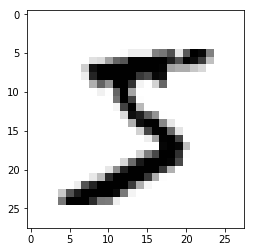

In [10]:
from matplotlib import pyplot as plt
plt.imshow(X[0].reshape((28,28)), cmap='binary')
plt.show()

In [11]:
y[0]

'5'

Split the data into testing and training data

In [16]:
size_train = 60000
X_train = X[:size_train]
X_test = X[size_train:]
y_train = y[:size_train].astype(np.uint8)
y_test = y[size_train:].astype(np.uint8)

Start with the binary test "is this a 5"

In [17]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5
print(f'{sum(y_train_5)} {sum(y_test_5)}')

5421 892


Train an SGD classifier

In [19]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=1811, max_iter=1000, tol=1e-3)
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=1811, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [86]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv=10, scoring="accuracy", n_jobs=10)

array([0.97133811, 0.96266667, 0.93233333, 0.96216667, 0.96066667,
       0.9425    , 0.96116667, 0.94283333, 0.95883333, 0.96149358])

Compare with a "dumb" classifier

In [26]:
from sklearn.base import BaseEstimator

class NeverFive(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((X.shape[0], 1))
    
cross_val_score(NeverFive(), X_train, y_train_5, cv=10, scoring="accuracy")

array([0.91433333, 0.911     , 0.91016667, 0.90716667, 0.90583333,
       0.91316667, 0.90766667, 0.91      , 0.90866667, 0.9085    ])

In [27]:
from sklearn.model_selection import cross_val_predict
yhat_train_5 = cross_val_predict(sgd, X_train, y_train_5, cv=10, n_jobs=10)

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, yhat_train_5)

array([[53431,  1148],
       [ 1516,  3905]])

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'precison: {precision_score(y_train_5, yhat_train_5)} recall:{recall_score(y_train_5, yhat_train_5)} F:{f1_score(y_train_5, yhat_train_5)}')

precison: 0.7728082327330299 recall:0.7203467994834901 F:0.7456559098720642


In [32]:
a_train_5 = cross_val_predict(sgd, X_train, y_train_5, cv=10, n_jobs=10, method='decision_function')

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, a_train_5)

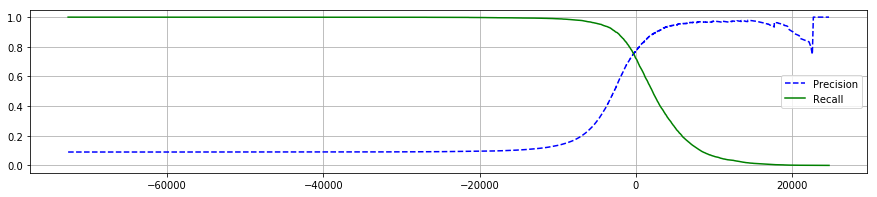

In [45]:
fig,ax = plt.subplots(figsize=(15,3))

ax.plot(thresholds, precisions[:-1], 'b--', label='Precision')
ax.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.grid(True)
plt.legend()

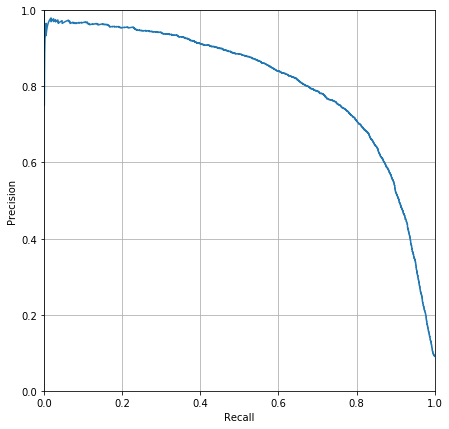

In [53]:
fig,ax = plt.subplots(figsize=(7,7))

ax.plot(recalls, precisions)
ax.set(xlabel='Recall', ylabel='Precision', xlim=(0,1), ylim=(0,1))
plt.grid(True)
#plt.legend()

In [62]:
threshold_90_precision = thresholds[precisions[1:] >= 0.9][0]

In [63]:
threshold_90_precision

2542.043198160346

In [64]:
precision_score(y_train_5, a_train_5 > threshold_90_precision)

0.9

In [65]:
recall_score(y_train_5, a_train_5 > threshold_90_precision)

0.4548976203652463

In [68]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train_5, a_train_5)

Text(0.5, 1.0, 'ROC AUC: 0.961')

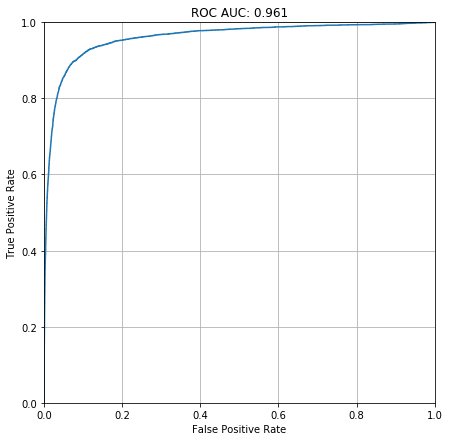

In [84]:
fig,ax = plt.subplots(figsize=(7,7))

ax.plot(fpr, tpr)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', xlim=(0,1), ylim=(0,1))
plt.grid(True)
plt.title(f'ROC AUC: {roc_auc_score(y_train_5, a_train_5):.3f}')
#plt.legend()

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1811)
a_train_5_rf = cross_val_predict(rf, X_train, y_train_5, cv=10, n_jobs=10, method='predict_proba')[:,1]

In [78]:
a_train_5_rf

array([0.9, 0. , 0.1, ..., 1. , 0. , 0. ])

In [79]:
fpr_rf, tpr_rf, threholds_rf = roc_curve(y_train_5, a_train_5_rf)

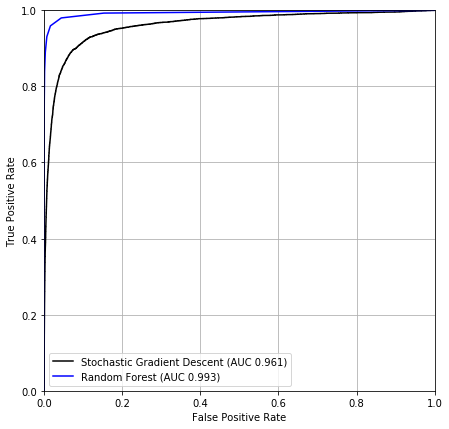

In [85]:
fig,ax = plt.subplots(figsize=(7,7))

ax.plot(fpr, tpr, color='black', label=f"Stochastic Gradient Descent (AUC {roc_auc_score(y_train_5, a_train_5):.3f})")
ax.plot(fpr_rf, tpr_rf, color='blue', label=f"Random Forest (AUC {roc_auc_score(y_train_5, a_train_5_rf):.3f})")
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', xlim=(0,1), ylim=(0,1))
plt.grid(True)
plt.legend()

In [88]:
precision_score(y_train_5, a_train_5_rf > 0.5)

0.9852750108271979

In [89]:
recall_score(y_train_5, a_train_5_rf > 0.5)

0.8393285371702638